In [1]:
import pandas as pd
import numpy as np
from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt

In [2]:
movielens_data_file_url = (
    "http://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
)
movielens_zipped_file = keras.utils.get_file(
    "ml-latest-small.zip", movielens_data_file_url, extract=False
)
keras_datasets_path = Path(movielens_zipped_file).parents[0]
movielens_dir = keras_datasets_path / "ml-latest-small"

# Only extract the data the first time the script is run.
if not movielens_dir.exists():
    with ZipFile(movielens_zipped_file, "r") as zip:
        # Extract files
        print("Extracting all the files now...")
        zip.extractall(path=keras_datasets_path)
        print("Done!")

ratings_file = movielens_dir / "ratings.csv"
df = pd.read_csv(ratings_file)

991232/978202 [==============================] - 0s 0us/step
Extracting all the files now...
Done!


In [3]:
user_ids = df["userId"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}
movie_ids = df["movieId"].unique().tolist()
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}
df["user"] = df["userId"].map(user2user_encoded)
df["movie"] = df["movieId"].map(movie2movie_encoded)

num_users = len(user2user_encoded)
num_movies = len(movie_encoded2movie)
df["rating"] = df["rating"].values.astype(np.float32)
# min and max ratings will be used to normalize the ratings later
min_rating = min(df["rating"])
max_rating = max(df["rating"])

print(
    "Number of users: {}, Number of Movies: {}, Min rating: {}, Max rating: {}".format(
        num_users, num_movies, min_rating, max_rating
    )
)

Number of users: 610, Number of Movies: 9724, Min rating: 0.5, Max rating: 5.0


In [4]:
df = df.sample(frac=1, random_state=42)
x = df[["user", "movie"]].values
# Normalize the targets between 0 and 1. Makes it easy to train.
y = df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
# Assuming training on 90% of the data and validating on 10%.
train_indices = int(0.9 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

In [5]:
EMBEDDING_SIZE = 50


class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.movie_bias = layers.Embedding(num_movies, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])
        dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)
        # Add all the components (including bias)
        x = dot_user_movie + user_bias + movie_bias
        # The sigmoid activation forces the rating to between 0 and 1
        return tf.nn.sigmoid(x)


model = RecommenderNet(num_users, num_movies, EMBEDDING_SIZE)
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(), optimizer=keras.optimizers.Adam(lr=0.001)
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [6]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=5,
    verbose=1,
    validation_data=(x_val, y_val),
)

Epoch 1/5
1418/1418 [==============================] - 15s 8ms/step - loss: 0.6356 - val_loss: 0.6203
Epoch 2/5
1418/1418 [==============================] - 7s 5ms/step - loss: 0.6132 - val_loss: 0.6162
Epoch 3/5
1418/1418 [==============================] - 6s 5ms/step - loss: 0.6091 - val_loss: 0.6141
Epoch 4/5
1418/1418 [==============================] - 6s 5ms/step - loss: 0.6079 - val_loss: 0.6115
Epoch 5/5
1418/1418 [==============================] - 7s 5ms/step - loss: 0.6069 - val_loss: 0.6125


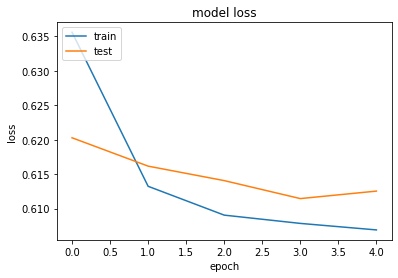

In [7]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

**1. (2 points) Train the model with more epochs and set the early stopping
condition so it is not overfitting. What do you observe in the training history
graph (e.g. does the validation loss continue to go down compared to the
current value of epochs=5)?**

In [12]:
from tensorflow.keras.callbacks import EarlyStopping

In [13]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

In [14]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=20, # change epoch from 5 to 20
    verbose=1,
    validation_data=(x_val, y_val),
    callbacks=[es] # use of callbacks for adding early stopping with patience = 5
)

Epoch 1/20
1418/1418 [==============================] - 11s 8ms/step - loss: 0.6047 - val_loss: 0.6108
Epoch 2/20
1418/1418 [==============================] - 10s 7ms/step - loss: 0.6043 - val_loss: 0.6121
Epoch 3/20
1418/1418 [==============================] - 11s 8ms/step - loss: 0.6051 - val_loss: 0.6130
Epoch 4/20
1418/1418 [==============================] - 12s 8ms/step - loss: 0.6041 - val_loss: 0.6142
Epoch 5/20
1418/1418 [==============================] - 11s 7ms/step - loss: 0.6058 - val_loss: 0.6118
Epoch 6/20
1418/1418 [==============================] - 11s 8ms/step - loss: 0.6057 - val_loss: 0.6129
Epoch 6: early stopping


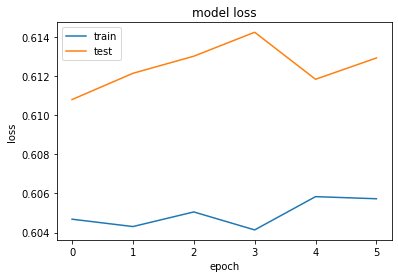

In [15]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

Model has stopped training because of early stopping with patience as 5. As validation loss has increased compare to epoch 1.

 **2. (3 points) Change batch_size to other values (32, 128, and 256). Which gives
the lowest loss? The notebook should show all the results.**

Batch Size = 32

Epoch 1/20
2836/2836 [==============================] - 15s 5ms/step - loss: 0.5976 - val_loss: 0.6092
Epoch 2/20
2836/2836 [==============================] - 14s 5ms/step - loss: 0.5957 - val_loss: 0.6108
Epoch 3/20
2836/2836 [==============================] - 21s 7ms/step - loss: 0.5965 - val_loss: 0.6107
Epoch 4/20
2836/2836 [==============================] - 14s 5ms/step - loss: 0.5967 - val_loss: 0.6108
Epoch 5/20
2836/2836 [==============================] - 14s 5ms/step - loss: 0.5971 - val_loss: 0.6116
Epoch 6/20
2836/2836 [==============================] - 14s 5ms/step - loss: 0.5969 - val_loss: 0.6113
Epoch 6: early stopping


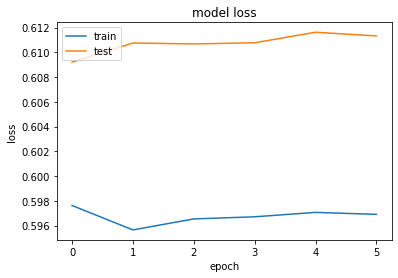

In [16]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=32,
    epochs=20, # change epoch from 5 to 20
    verbose=1,
    validation_data=(x_val, y_val),
    callbacks=[es] # use of callbacks for adding early stopping with patience = 5
)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

Batch Size = 128

Epoch 1/20
709/709 [==============================] - 6s 7ms/step - loss: 0.6367 - val_loss: 0.6480
Epoch 2/20
709/709 [==============================] - 5s 7ms/step - loss: 0.6494 - val_loss: 0.6352
Epoch 3/20
709/709 [==============================] - 5s 7ms/step - loss: 0.6509 - val_loss: 0.6445
Epoch 4/20
709/709 [==============================] - 5s 7ms/step - loss: 0.6521 - val_loss: 0.6340
Epoch 5/20
709/709 [==============================] - 5s 7ms/step - loss: 0.6493 - val_loss: 0.6393
Epoch 6/20
709/709 [==============================] - 5s 7ms/step - loss: 0.6437 - val_loss: 0.6347
Epoch 7/20
709/709 [==============================] - 5s 7ms/step - loss: 0.6402 - val_loss: 0.6378
Epoch 8/20
709/709 [==============================] - 5s 7ms/step - loss: 0.6403 - val_loss: 0.6325
Epoch 9/20
709/709 [==============================] - 5s 7ms/step - loss: 0.6392 - val_loss: 0.6346
Epoch 10/20
709/709 [==============================] - 5s 7ms/step - loss: 0.6370 - val_loss: 0.6343

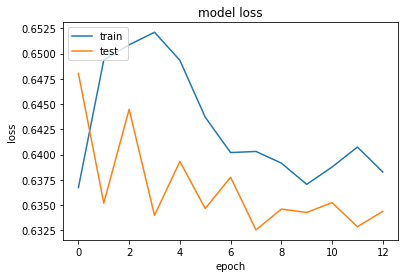

In [17]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=128,
    epochs=20, # change epoch from 5 to 20
    verbose=1,
    validation_data=(x_val, y_val),
    callbacks=[es] # use of callbacks for adding early stopping with patience = 5
)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

Batch Size = 256

Epoch 1/20
355/355 [==============================] - 3s 7ms/step - loss: 0.6983 - val_loss: 0.6898
Epoch 2/20
355/355 [==============================] - 3s 7ms/step - loss: 0.7024 - val_loss: 0.6733
Epoch 3/20
355/355 [==============================] - 3s 7ms/step - loss: 0.7627 - val_loss: 0.8149
Epoch 4/20
355/355 [==============================] - 3s 7ms/step - loss: 0.7936 - val_loss: 0.7170
Epoch 5/20
355/355 [==============================] - 3s 7ms/step - loss: 0.8640 - val_loss: 0.8481
Epoch 6/20
355/355 [==============================] - 2s 7ms/step - loss: 0.8656 - val_loss: 0.6961
Epoch 7/20
355/355 [==============================] - 3s 7ms/step - loss: 0.8530 - val_loss: 0.7517
Epoch 7: early stopping


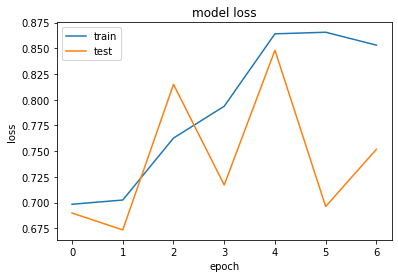

In [18]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=256,
    epochs=20, # change epoch from 5 to 20
    verbose=1,
    validation_data=(x_val, y_val),
    callbacks=[es] # use of callbacks for adding early stopping with patience = 5
)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

Batch 32 ig giving lowest validation loss

**3. (3 points) Use the batch_size value that gives the lowest loss. Change
EMBEDDING_SIZE to other values (100, 150, and 200). Which gives the
lowest loss? The notebook should show all the results.**

EMBEDDING_SIZE = 100

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


2836/2836 [==============================] - 17s 5ms/step - loss: 0.6321 - val_loss: 0.6202
Epoch 2/20
2836/2836 [==============================] - 14s 5ms/step - loss: 0.6171 - val_loss: 0.6193
Epoch 3/20
2836/2836 [==============================] - 14s 5ms/step - loss: 0.6190 - val_loss: 0.6202
Epoch 4/20
2836/2836 [==============================] - 15s 5ms/step - loss: 0.6220 - val_loss: 0.6199
Epoch 5/20
2836/2836 [==============================] - 14s 5ms/step - loss: 0.6219 - val_loss: 0.6214
Epoch 6/20
2836/2836 [==============================] - 15s 5ms/step - loss: 0.6246 - val_loss: 0.6215
Epoch 7/20
2836/2836 [==============================] - 14s 5ms/step - loss: 0.6251 - val_loss: 0.6219
Epoch 7: early stopping


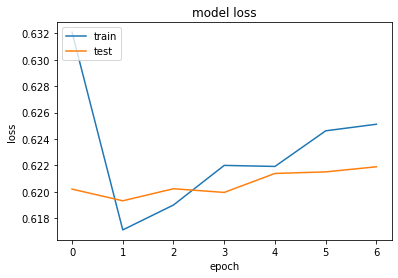

In [19]:
model = RecommenderNet(num_users, num_movies, 100)
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(), optimizer=keras.optimizers.Adam(lr=0.001)
)
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=32,
    epochs=20, # change epoch from 5 to 20
    verbose=1,
    validation_data=(x_val, y_val),
    callbacks=[es] # use of callbacks for adding early stopping with patience = 5
)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

EMBEDDING_SIZE = 150

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


2836/2836 [==============================] - 17s 6ms/step - loss: 0.6323 - val_loss: 0.6228
Epoch 2/20
2836/2836 [==============================] - 15s 5ms/step - loss: 0.6297 - val_loss: 0.6310
Epoch 3/20
2836/2836 [==============================] - 15s 5ms/step - loss: 0.6444 - val_loss: 0.6331
Epoch 4/20
2836/2836 [==============================] - 15s 5ms/step - loss: 0.6542 - val_loss: 0.6323
Epoch 5/20
2836/2836 [==============================] - 15s 5ms/step - loss: 0.6544 - val_loss: 0.6345
Epoch 6/20
2836/2836 [==============================] - 15s 5ms/step - loss: 0.6605 - val_loss: 0.6329
Epoch 6: early stopping


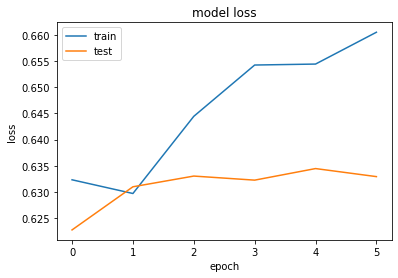

In [20]:
model = RecommenderNet(num_users, num_movies, 150)
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(), optimizer=keras.optimizers.Adam(lr=0.001)
)
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=32,
    epochs=20, # change epoch from 5 to 20
    verbose=1,
    validation_data=(x_val, y_val),
    callbacks=[es] # use of callbacks for adding early stopping with patience = 5
)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

EMBEDDING_SIZE = 200

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


2836/2836 [==============================] - 17s 6ms/step - loss: 0.6338 - val_loss: 0.6252
Epoch 2/20
2836/2836 [==============================] - 16s 6ms/step - loss: 0.6454 - val_loss: 0.6389
Epoch 3/20
2836/2836 [==============================] - 16s 6ms/step - loss: 0.6803 - val_loss: 0.6467
Epoch 4/20
2836/2836 [==============================] - 16s 6ms/step - loss: 0.6936 - val_loss: 0.6535
Epoch 5/20
2836/2836 [==============================] - 17s 6ms/step - loss: 0.7052 - val_loss: 0.6552
Epoch 6/20
2836/2836 [==============================] - 16s 6ms/step - loss: 0.7079 - val_loss: 0.6572
Epoch 6: early stopping


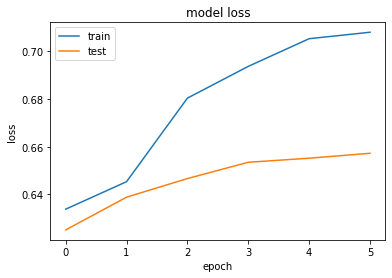

In [21]:
model = RecommenderNet(num_users, num_movies, 200)
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(), optimizer=keras.optimizers.Adam(lr=0.001)
)
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=32,
    epochs=20, # change epoch from 5 to 20
    verbose=1,
    validation_data=(x_val, y_val),
    callbacks=[es] # use of callbacks for adding early stopping with patience = 5
)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

EMBEDDING_SIZE = 100 has the lowest validation loss.

**4. (2 points) Provide the top 10 movies for each user and save in a Excel file
with the following columns user id, movie title, and movie genre.**

In [37]:
user_id_list = []
movie_title_list = []
movies_genre_list = []

In [38]:
user_ids = df["userId"].unique().tolist()
movie_df = pd.read_csv(movielens_dir / "movies.csv")

In [ ]:
for i in user_ids:
    print(i)
    user_id = i
    movies_watched_by_user = df[df.userId == user_id]
    movies_not_watched = movie_df[
        ~movie_df["movieId"].isin(movies_watched_by_user.movieId.values)
    ]["movieId"]
    movies_not_watched = list(
        set(movies_not_watched).intersection(set(movie2movie_encoded.keys()))
    )
    movies_not_watched = [[movie2movie_encoded.get(x)] for x in movies_not_watched]
    user_encoder = user2user_encoded.get(user_id)
    user_movie_array = np.hstack(
        ([[user_encoder]] * len(movies_not_watched), movies_not_watched)
    )
    ratings = model.predict(user_movie_array).flatten()
    top_ratings_indices = ratings.argsort()[-10:][::-1]
    recommended_movie_ids = [
        movie_encoded2movie.get(movies_not_watched[x][0]) for x in top_ratings_indices
    ]
    recommended_movies = movie_df[movie_df["movieId"].isin(recommended_movie_ids)]
    for row in recommended_movies.itertuples():
        user_id_list.append(user_id)
        movie_title_list.append(row.title)
        movies_genre_list.append(row.genres)

In [41]:
len(user_id_list),len(movie_title_list),len(movies_genre_list)

(6100, 6100, 6100)

In [45]:
data = pd.DataFrame([user_id_list,movie_title_list,movies_genre_list]) #Each list would be added as a row
data = data.transpose() #To Transpose and make each rows as columns
data.columns=['User Id', 'Movie Titile', 'Movie Genre'] #Rename the columns

In [46]:
data.head()

,User Id,Movie Titile,Movie Genre
0,432,Rear Window (1954),Mystery|Thriller
1,432,Cool Hand Luke (1967),Drama
2,432,"Great Dictator, The (1940)",Comedy|Drama|War
3,432,High Noon (1952),Drama|Western
4,432,This Is Spinal Tap (1984),Comedy


In [47]:
data.to_csv("User_Recommendation.csv")